# import dependency

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences
import numpy as np
import numpy.ma as ma  
import pandas as pd
import csv
import random
import seaborn as sns
from joblib import load, dump
from sklearn.model_selection import train_test_split
import amp.data_utils.data_loader as data_loader
from amp.config import MIN_LENGTH, MAX_LENGTH
from amp.data_utils.sequence import pad, to_one_hot
from amp.utils.generate_peptides import translate_peptide
from amp.utils import phys_chem_propterties as phys
from amp.inference import HydrAMPGenerator
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from scipy.stats import mannwhitneyu

import modlamp.descriptors
import modlamp.analysis
import modlamp.sequences


Using TensorFlow backend.


# Amino acid composition

In [2]:
seed = 7
# sns.set_style('whitegrid', {'grid.color': '.95', 'axes.spines.right': False, 'axes.spines.top': False})
params = {'axes.labelsize': 20,'axes.titlesize':20, 'font.size': 20, 'legend.fontsize': 20, 'xtick.labelsize': 20, 'ytick.labelsize': 20}
plt.rcParams.update(params)

In [3]:
def get_aa_composition(data):
    STD_AA = list('ACDEFGHIKLMNPQRSTVWY')
    seq = ''.join(data)
    count = len(seq)

    aa_comp = {}
    for aa in STD_AA:
        aa_comp[aa] = seq.count(aa) / count
    return aa_comp

In [ ]:
amp_result_f = open('../results/hydramp/amp_case1.csv','r')
mic_result_f = open('../results/hydramp/mic_case1.csv','r')
amp_mic_result_f = open('../results/hydramp/amp_mic_case1.csv','r')
amp_result_reader = csv.reader(amp_result_f)
mic_result_reader = csv.reader(mic_result_f)
amp_mic_result_reader = csv.reader(amp_mic_result_f)
next(amp_result_reader)
next(mic_result_reader)
next(amp_mic_result_reader)
prototype_list = []
amp_PepZOO_list = []
mic_PepZOO_list = []
amp_mic_PepZOO_list = []

for row in amp_result_reader:
    _, t = row[0].split('_')
    if t == 'original':
        prototype_list.append(row[1])
    if t == 'HydrampZeroOpt':
        amp_PepZOO_list.append(row[1])

for row in mic_result_reader:
    _, t = row[0].split('_')
    if t == 'HydrampZeroOpt':
        mic_PepZOO_list.append(row[1])

for row in amp_mic_result_reader:
    _, t = row[0].split('_')
    if t == 'HydrampZeroOpt':
        amp_mic_PepZOO_list.append(row[1])

amp_result_f.close()
mic_result_f.close()
amp_mic_result_f.close()

COLOR_SCALE = ["#8ecfc9", "#ffbe7a", "#fa7f6f", '#82b0d2', '#aeadd3']
fig = plt.figure(figsize=(12,7), dpi=300)
padding = [0, 0.15, 0.3, 0.45]

aa_composition = get_aa_composition(prototype_list)
x = np.arange(len(list(aa_composition.keys())))
plt.bar(x + padding[0], list(aa_composition.values()), width=0.15, color=COLOR_SCALE[0], label='Prototype')

aa_composition = get_aa_composition(amp_PepZOO_list)
x = np.arange(len(list(aa_composition.keys())))
plt.bar(x + padding[1], list(aa_composition.values()), width=0.15, color=COLOR_SCALE[1], label='PepZOO-AMP')

aa_composition = get_aa_composition(mic_PepZOO_list)
x = np.arange(len(list(aa_composition.keys())))
plt.bar(x + padding[2], list(aa_composition.values()), width=0.15, color=COLOR_SCALE[2], tick_label=list(aa_composition.keys()), label='PepZOO-MIC')

aa_composition = get_aa_composition(amp_mic_PepZOO_list)
x = np.arange(len(list(aa_composition.keys())))
plt.bar(x + padding[3], list(aa_composition.values()), width=0.15, color=COLOR_SCALE[3], label='PepZOO-AMP_MIC')

plt.ylim(0, 0.20)  # 设置 y 轴数值范围
plt.yticks([0, 0.05, 0.10, 0.15, 0.20])  # 设置 y 轴刻度位置    
plt.xticks(fontsize=22)  # 设置x轴刻度字体大小
plt.yticks(fontsize=22)  # 设置y轴刻度字体大小
plt.legend(fontsize=22)

plt.xlabel('Amino Acids', fontsize=24)
plt.ylabel('Fraction', fontsize=24)
# plt.title("Case 1", fontsize=24)
plt.savefig('figure/case1_all_aacomposition.svg')
plt.show()

# P_AMP and P_MIC

In [6]:
# sns.set_style(
#     'whitegrid', 
#     {
#         'grid.color': '.95',
#         'axes.spines.right': False,
#         'axes.spines.top': False,
#     }
# )

params = {
    'axes.labelsize': 50,
    'axes.titlesize':50,
    'font.size': 50, 
    'legend.fontsize': 50,
    'xtick.labelsize': 50, 
    'ytick.labelsize': 50,
}

plt.rcParams.update(params)

palette_models = {  
    'Prototype': '#ffd23f',
    'PepZOO_amp': '#AF55FF',
    'PepZOO_mic': '#A69FFF',
    'PepZOO_amp_mic': '#B80018',
    'HydrAMP': '#1d3557',
    'PepCVAE': '#0F5257',     
    'Basic': '#660708',         
}

## P_AMP

In [7]:
def get_amp_mic_data(amp_file_path, mic_file_path, amp_mic_file_path, pepcvae_file_path, basic_file_path):
    data = []
    amp_file = open(amp_file_path,'r')
    mic_file = open(mic_file_path,'r')
    amp_mic_file = open(amp_mic_file_path,'r')
    pepcvae_file = open(pepcvae_file_path,'r')
    basic_file = open(basic_file_path,'r')

    amp_reader = csv.reader(amp_file)
    mic_reader = csv.reader(mic_file)
    amp_mic_reader = csv.reader(amp_mic_file)
    pepcvae_reader = csv.reader(pepcvae_file)
    basic_reader = csv.reader(basic_file)

    next(amp_reader)
    next(mic_reader)
    next(amp_mic_reader)
    next(basic_reader)
    next(pepcvae_reader)

    prototype_amp_list = []

    hydramp_amp_list = []

    amp_amp_list = []

    mic_amp_list = []

    amp_mic_amp_list = []

    basic_amp_list = []

    pepcvae_amp_list = []

    for row in amp_reader:
        _, t = row[0].split('_')
        if t == 'original':
            prototype_amp_list.append(float(row[2]))
        if t == 'HydrampOpt':
            hydramp_amp_list.append(float(row[2]))
        if t == 'HydrampZeroOpt':
            amp_amp_list.append(float(row[2]))

    for row in mic_reader:
        _, t = row[0].split('_')
        if t == 'HydrampZeroOpt':
            mic_amp_list.append(float(row[2]))

    for row in amp_mic_reader:
        _, t = row[0].split('_')
        if t == 'HydrampZeroOpt':
            amp_mic_amp_list.append(float(row[2]))

    for row in basic_reader:
        _, t = row[0].split('_')
        if t == 'BasicOpt':
            basic_amp_list.append(float(row[2]))

    for row in pepcvae_reader:
        _, t = row[0].split('_')
        if t == 'PepCVAEOpt':
            pepcvae_amp_list.append(float(row[2]))
    data.append([prototype_amp_list])
    data.append([amp_amp_list])
    data.append([mic_amp_list])
    data.append([amp_mic_amp_list])
    data.append([hydramp_amp_list]) 
    data.append([pepcvae_amp_list])  
    data.append([basic_amp_list])
    amp_file.close()
    mic_file.close()
    amp_mic_file.close()
    basic_file.close()
    pepcvae_file.close()  
    return data


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.array([np.percentile(data_, [25, 50, 75], axis=0) for data_ in data]).T
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    # ax.set_xticks([1,2,3,4])
    # ax.set_xticklabels([k,k,k,k])


def generate_classifier_distribution_plot(
    optimized_amp,
):
    

    fig, ax1 = plt.subplots(
        figsize=(21, 12),
        dpi=300,
        sharey=True,
    )

    parts1 = ax1.violinplot(
        dataset=optimized_amp,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )

    set_axis_style(ax1, optimized_amp, 'Optimized')

    # ax1.spines['left'].set_visible(False)

    for pc, color in zip(parts1['bodies'], palette_models.values()):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.0)
        pc.set_alpha(1)
    
    # ax1.annotate('a', xy=(-0.1, 1.10), xycoords='axes fraction',fontweight='bold', va='top', ha='right', fontsize=17)
    ax1.yaxis.set_major_formatter('{:.2f}'.format)
    ax1.set_xticks([1,2,3,4,5,6,7])
    ax1.set_xticklabels([])
    # ax1.set_xticklabels(['Prototype', 'PepZOO-AMP', 'PepZOO-MIC', 'PepZOO-AMP_MIC', 'HydrAMP', 'PepCVAE', 'Basic'])
    ax1.set_ylabel('$P_{AMP}$', fontsize=55)
    # ax1.annotate('Case 1', xy=(0.5, 1.10), xycoords='axes fraction', fontweight='bold', va='top', ha='right', fontsize=10) 
    # ax1.set_xticklabels([])
    # fig.autofmt_xdate(rotation=45)
    return fig


def plot_classifier_distribution(data):
    
    optimized_amp = [x[0] for x in data]
    
    fig = generate_classifier_distribution_plot(
        optimized_amp,
    )

    return fig    

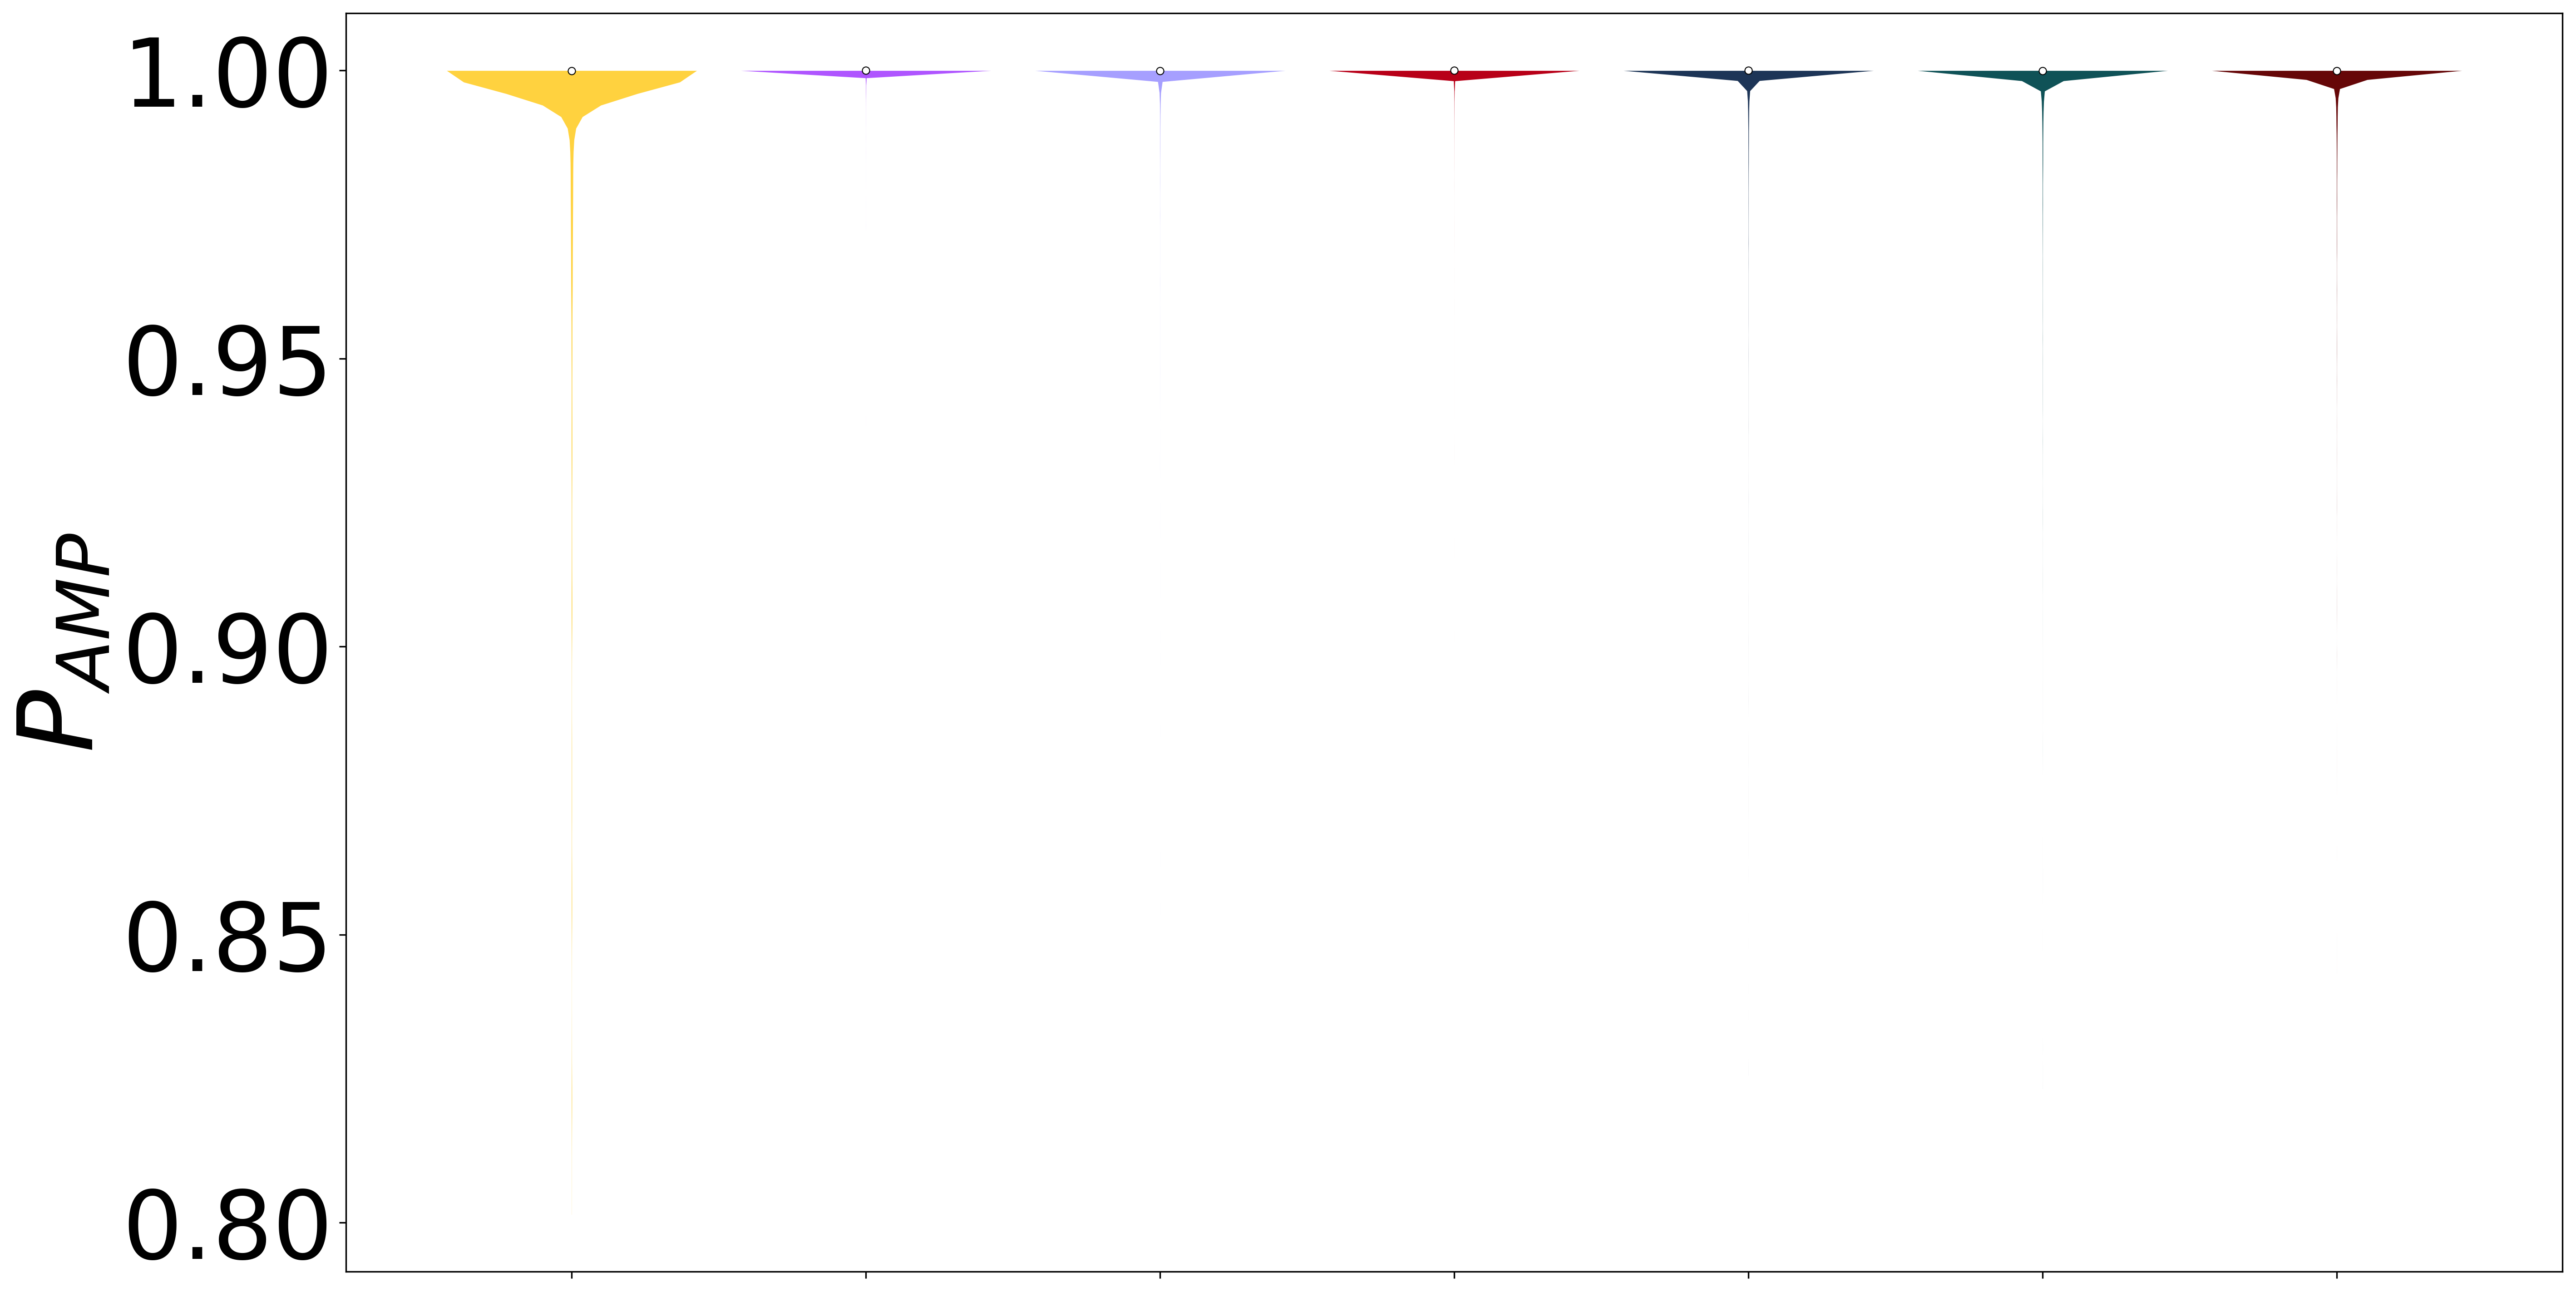

In [8]:
amp_file_path = '../results/hydramp/amp_case1.csv'
mic_file_path = '../results/hydramp/mic_case1.csv'
amp_mic_file_path = '../results/hydramp/amp_mic_case1.csv'
pepcvae_file_path  = '../results/pepcvae/case1_result.csv'
basic_file_path = '../results/basic/case1_result.csv'
data = get_amp_mic_data(amp_file_path, mic_file_path, amp_mic_file_path, pepcvae_file_path, basic_file_path)
fig = plot_classifier_distribution(data)
# plt.legend(
#     handles=[ 
#         mpatches.Patch(color=palette_models['Prototype'], label='Prototype'),
#         mpatches.Patch(color=palette_models['PepZOO_amp'], label='PepZOO_AMP'),          
#         mpatches.Patch(color=palette_models['PepZOO_mic'], label='PepZOO_MIC'),
#         mpatches.Patch(color=palette_models['PepZOO_amp_mic'], label='PepZOO_AMP_MIC'),
#         mpatches.Patch(color=palette_models['HydrAMP'], label='HydrAMP'),
#         mpatches.Patch(color=palette_models['PepCVAE'], label='PepCVAE'),
#         mpatches.Patch(color=palette_models['Basic'], label='Basic'),
#     ], 
#     bbox_to_anchor = (1.2, 0.0),
#     ncol=2,
# )
fig.savefig("figure/case1_amp.pdf")

## P_MIC

In [9]:
def get_amp_mic_data(amp_file_path, mic_file_path, amp_mic_file_path, pepcvae_file_path, basic_file_path):
    data = []

    amp_file = open(amp_file_path,'r')
    mic_file = open(mic_file_path,'r')
    amp_mic_file = open(amp_mic_file_path,'r')
    pepcvae_file = open(pepcvae_file_path,'r')
    basic_file = open(basic_file_path,'r')

    amp_reader = csv.reader(amp_file)
    mic_reader = csv.reader(mic_file)
    amp_mic_reader = csv.reader(amp_mic_file)
    pepcvae_reader = csv.reader(pepcvae_file)
    basic_reader = csv.reader(basic_file)

    next(amp_reader)
    next(mic_reader)
    next(amp_mic_reader)
    next(basic_reader)
    next(pepcvae_reader)

    prototype_mic_list = []

    amp_mic_list = []

    mic_mic_list = []

    amp_mic_mic_list = []

    hydramp_mic_list = []

    pepcvae_mic_list = []

    basic_mic_list = []

    for row in amp_reader:
        _, t = row[0].split('_')
        if t == 'original':
            prototype_mic_list.append(float(row[3]))
        if t == 'HydrampOpt':
            hydramp_mic_list.append(float(row[3]))
        if t == 'HydrampZeroOpt':
            amp_mic_list.append(float(row[3]))

    for row in mic_reader:
        _, t = row[0].split('_')
        if t == 'HydrampZeroOpt':
            mic_mic_list.append(float(row[3]))

    for row in amp_mic_reader:
        _, t = row[0].split('_')
        if t == 'HydrampZeroOpt':
            amp_mic_mic_list.append(float(row[3]))

    for row in pepcvae_reader:
        _, t = row[0].split('_')
        if t == 'PepCVAEOpt':
            pepcvae_mic_list.append(float(row[3]))

    for row in basic_reader:
        _, t = row[0].split('_')
        if t == 'BasicOpt':
            basic_mic_list.append(float(row[3]))

    data.append([prototype_mic_list])
    data.append([amp_mic_list])
    data.append([mic_mic_list])
    data.append([amp_mic_mic_list])
    data.append([hydramp_mic_list]) 
    data.append([pepcvae_mic_list])  
    data.append([basic_mic_list])
    amp_file.close()
    mic_file.close()
    amp_mic_file.close()
    basic_file.close()
    pepcvae_file.close()  
    return data


def adjacent_values(vals, q1, q3):
    upper_adjacent_value = q3 + (q3 - q1) * 1.5
    upper_adjacent_value = np.clip(upper_adjacent_value, q3, vals[-1])

    lower_adjacent_value = q1 - (q3 - q1) * 1.5
    lower_adjacent_value = np.clip(lower_adjacent_value, vals[0], q1)
    return lower_adjacent_value, upper_adjacent_value


def set_axis_style(ax, data, k):
    quartile1, medians, quartile3 = np.array([np.percentile(data_, [25, 50, 75], axis=0) for data_ in data]).T
    whiskers = np.array([
        adjacent_values(sorted_array, q1, q3)
        for sorted_array, q1, q3 in zip(data, quartile1, quartile3)])
    inds = np.arange(1, len(medians) + 1)
    ax.scatter(inds, medians, marker='o', lw=0.5, edgecolors='k', color='white', s=15, zorder=3)
    ax.vlines(inds, quartile1, quartile3, color='k', linestyle='-', lw=0.5)
    ax.xaxis.set_ticks_position('bottom')
    # ax.set_xticks([1,2,3,4])
    # ax.set_xticklabels([k,k,k,k])


def generate_classifier_distribution_plot(
    optimized_mic,
):
    

    fig, ax1 = plt.subplots(
        figsize=(21, 12),
        dpi=300,
        sharey=True,
    )

    parts1 = ax1.violinplot(
        dataset=optimized_mic,
        showmeans=False,
        showmedians=False,
        showextrema=False,
        widths=0.85, 
    )

    set_axis_style(ax1, optimized_mic, 'Optimized')

    for pc, color in zip(parts1['bodies'], palette_models.values()):
        pc.set_facecolor(color)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.0)
        pc.set_alpha(1)
    
    # ax1.annotate('a', xy=(-0.1, 1.10), xycoords='axes fraction',fontweight='bold', va='top', ha='right', fontsize=17)
    ax1.yaxis.set_major_formatter('{:.2f}'.format)
    ax1.set_xticks([1,2,3,4,5,6,7])
    ax1.set_xticklabels([])
    # ax1.set_xticklabels(['Prototype', 'AMP', 'MIC', 'AMP_MIC', 'HydrAMP', 'PepCVAE', 'Basic'])
    ax1.set_ylabel('$P_{MIC}$', fontsize=55)
    # ax1.annotate('Case 1', xy=(0.5, 1.10), xycoords='axes fraction', fontweight='bold', va='top', ha='right', fontsize=10) 
    # fig.autofmt_xdate(rotation=45)
    return fig


def plot_classifier_distribution(data):
    
    optimized_mic = [x[0] for x in data]
    
    fig = generate_classifier_distribution_plot(
        optimized_mic,
    )

    return fig     

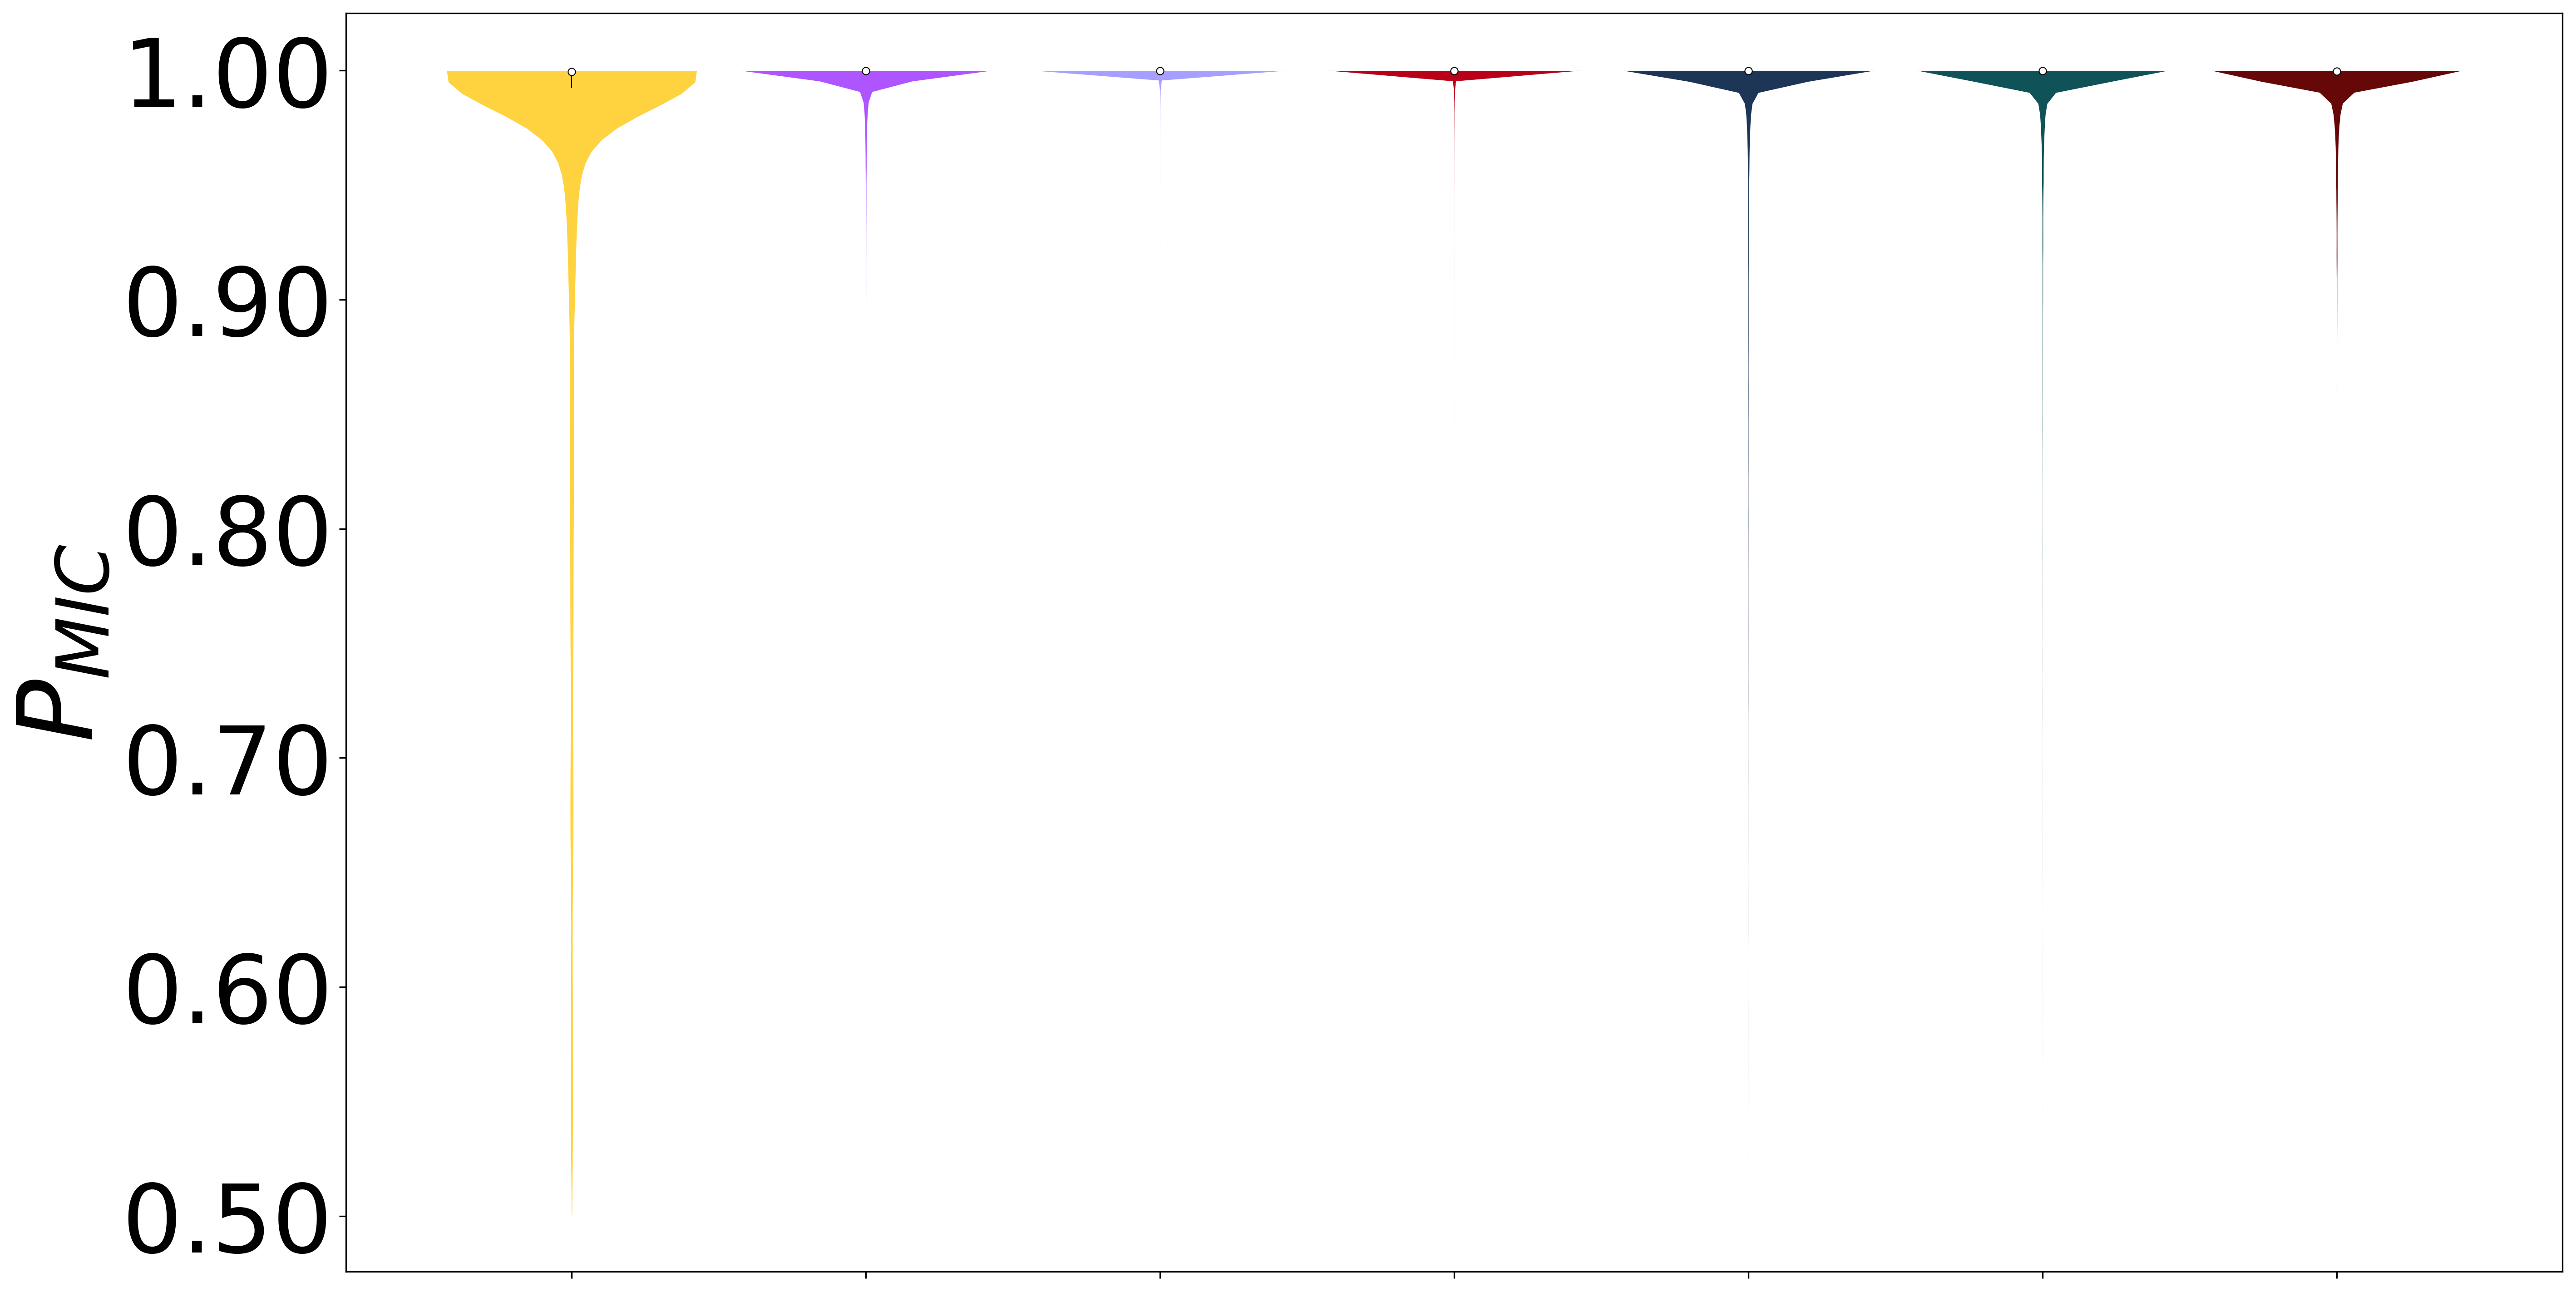

In [10]:
amp_file_path = '../results/hydramp/amp_case1.csv'
mic_file_path = '../results/hydramp/mic_case1.csv'
amp_mic_file_path = '../results/hydramp/amp_mic_case1.csv'
pepcvae_file_path  = '../results/pepcvae/case1_result.csv'
basic_file_path = '../results/basic/case1_result.csv'
data = get_amp_mic_data(amp_file_path, mic_file_path, amp_mic_file_path, pepcvae_file_path, basic_file_path)
fig = plot_classifier_distribution(data)
# plt.legend(
#     handles=[ 
#         mpatches.Patch(color=palette_models['Prototype'], label='Prototype'),
#         mpatches.Patch(color=palette_models['PepZOO_amp'], label='PepZOO_AMP'),          
#         mpatches.Patch(color=palette_models['PepZOO_mic'], label='PepZOO_MIC'),
#         mpatches.Patch(color=palette_models['PepZOO_amp_mic'], label='PepZOO_AMP_MIC'),
#         mpatches.Patch(color=palette_models['HydrAMP'], label='HydrAMP'),
#         mpatches.Patch(color=palette_models['PepCVAE'], label='PepCVAE'),
#         mpatches.Patch(color=palette_models['Basic'], label='Basic'),
#     ], 
#     bbox_to_anchor = (1.0, 0.0),
#     ncol=3,
# )
fig.savefig("figure/case1_mic.pdf")

# Novelty

In [11]:
from Levenshtein import distance
import pandas as pd
import numpy as np

df = pd.read_csv('../results/hydramp/case1_result_4_novelty.csv')

type_list = df['type'].to_list()
seq_list = df['sequence'].to_list()
amp_list = df['amp'].to_list()
mic_list = df['mic'].to_list()

origin_seq_list = []
origin_amp_list = []
origin_mic_list = []
opt_seq_list = [[''] * 5425 for i in range(100)]
opt_amp_list = np.zeros((100, 5425))
opt_mic_list = np.zeros((100, 5425))

for i in range(5425):
    origin_seq_list.append(seq_list[i])
    origin_amp_list.append(amp_list[i])
    origin_mic_list.append(mic_list[i])

for i in range(5425,76347):
    row = type_list[i].split('_')
    opt_seq_list[int(row[1])-1][int(row[0])-1] = seq_list[i]
    opt_amp_list[int(row[1])-1][int(row[0])-1] = amp_list[i]
    opt_mic_list[int(row[1])-1][int(row[0])-1] = mic_list[i]


novelty_list = []
better_list = []
for i in range(100):
    k = 0
    count = 0
    temp_dist = 0
    for j in range(5425):
        if opt_seq_list[i][j] != '':
           temp_dist = temp_dist + distance(origin_seq_list[j], opt_seq_list[i][j])
           k = k + 1
        if opt_amp_list[i][j] > origin_amp_list[j] and opt_mic_list[i][j] > origin_mic_list[j]:
            count = count + 1

    temp_dist = temp_dist / float(k)
    novelty_list.append(temp_dist)
    better_list.append(float(count) / 5425.0)

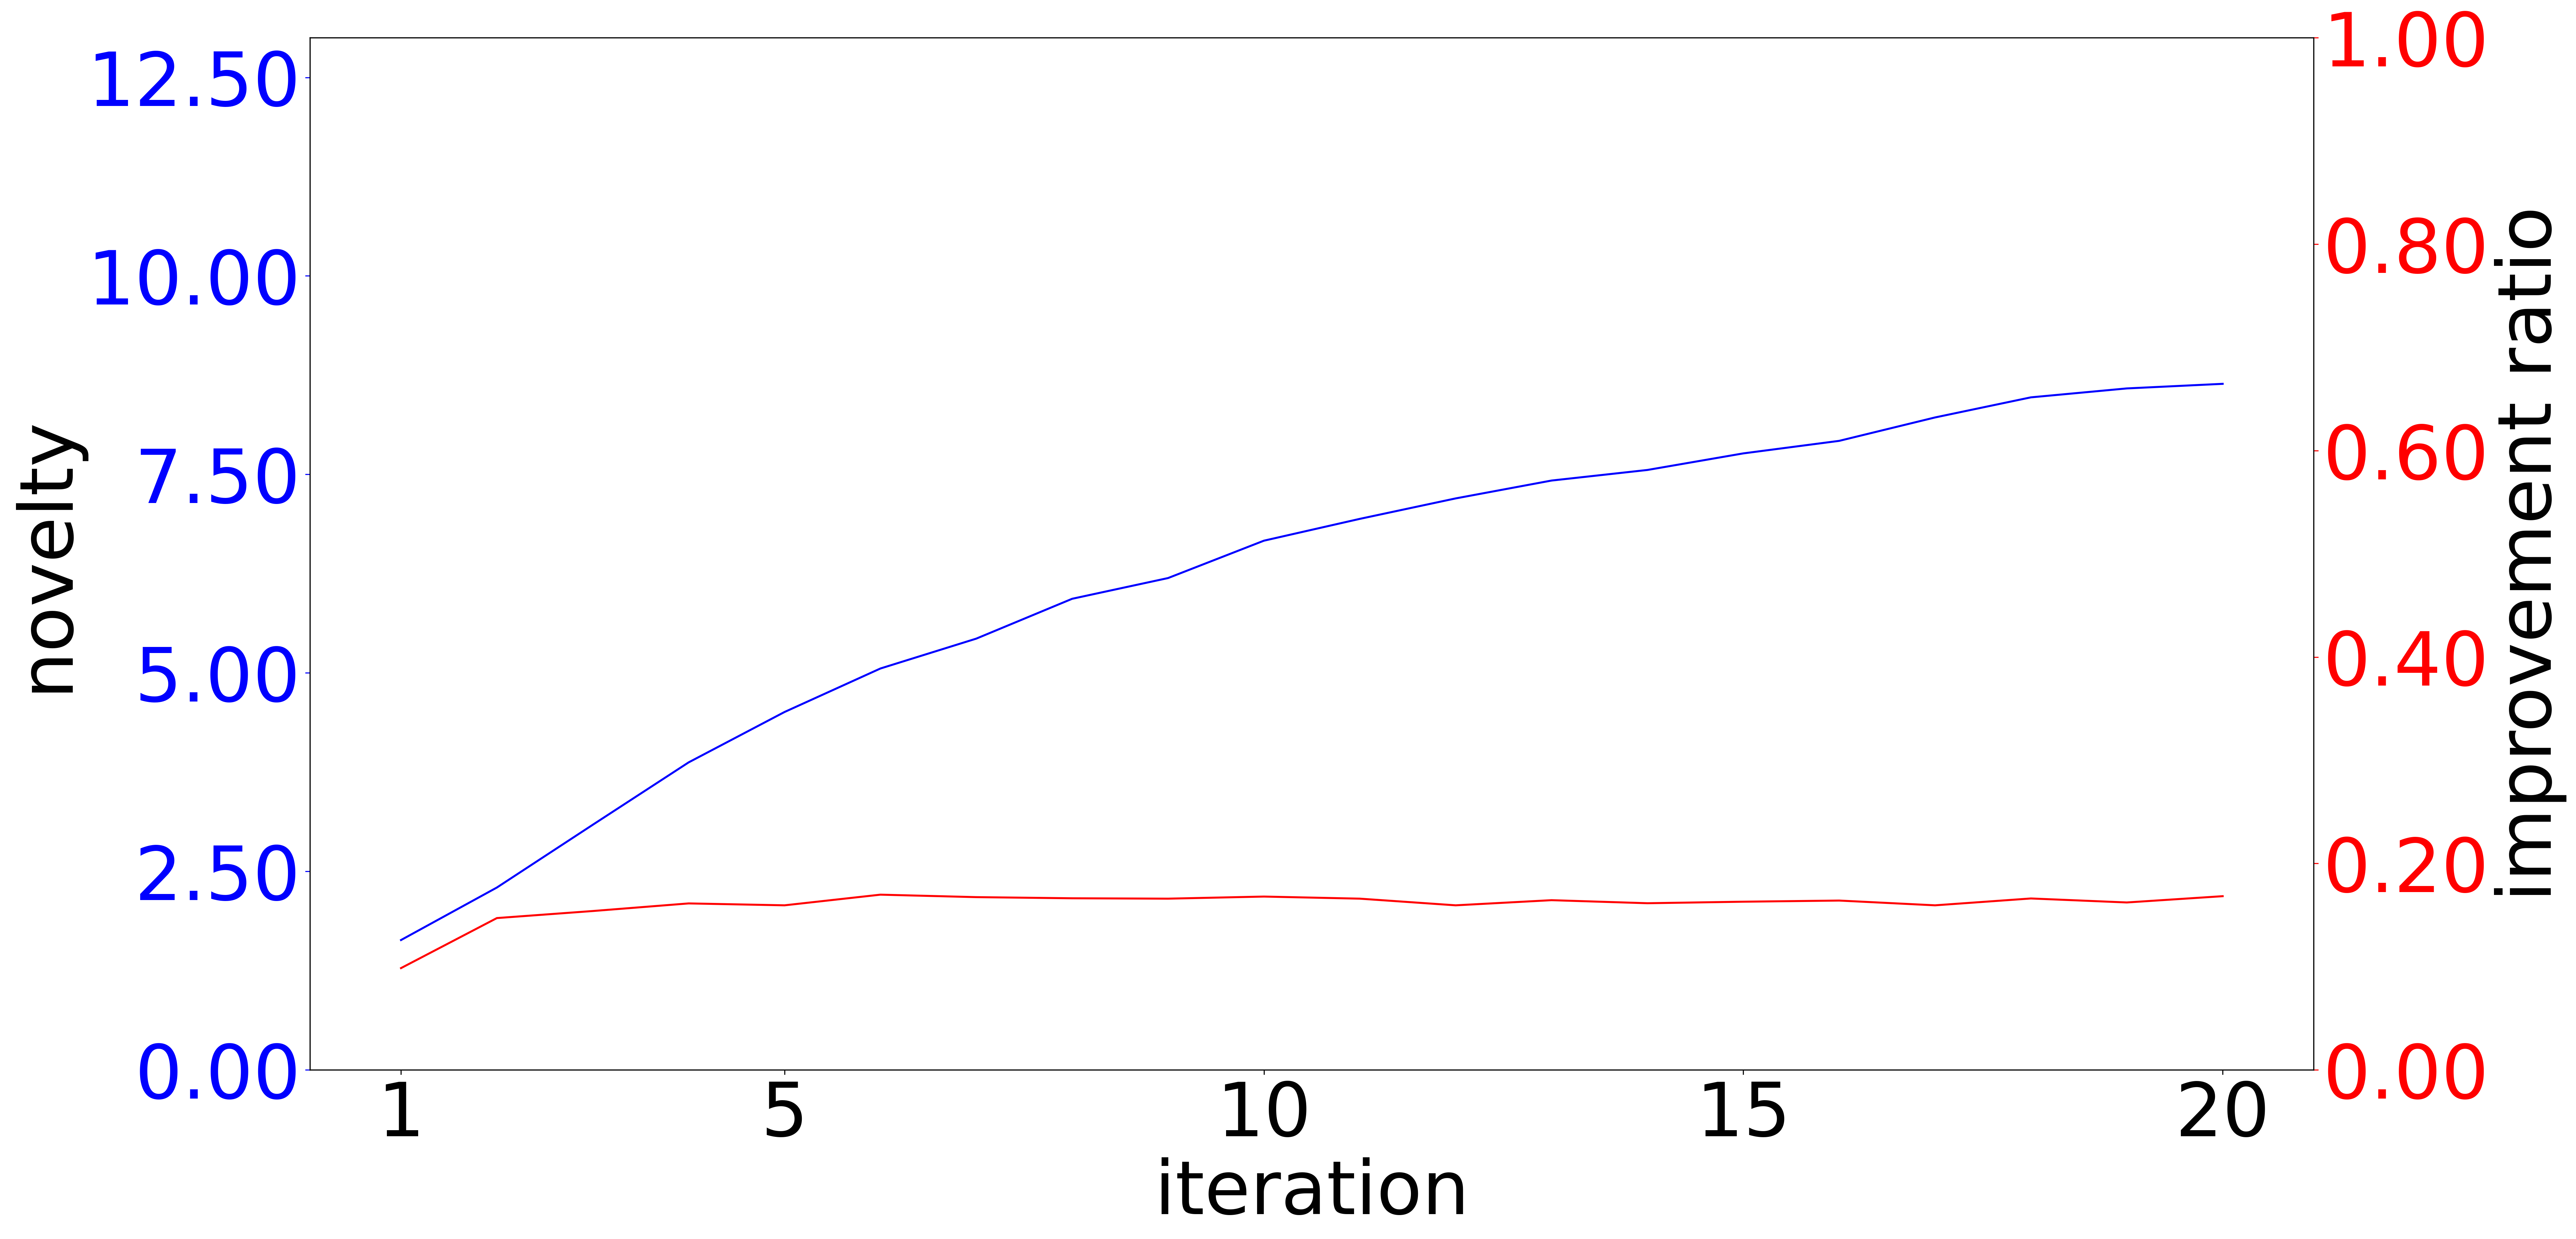

In [12]:
import numpy as np
import matplotlib.pyplot as plt
params = {
    'axes.labelsize': 56,
    'axes.titlesize':56,
    'font.size': 56, 
    'legend.fontsize': 56,
    'xtick.labelsize': 56, 
    'ytick.labelsize': 56,
}
plt.rcParams.update(params)

x = np.linspace(start = 0,stop = 19, num=20)

# y1 = list(map(float, y1))
# y2 = list(map(float, y2))
fig = plt.figure(figsize=(27,14),dpi=300)
ax = fig.add_subplot(111)
ax.plot(x,novelty_list[:20], '-', label = 'novelty', color='blue')
# 设置第一个y轴的范围
ax.set_ylim(0, 13)  
# 设置第一个y轴标签及颜色
ax.tick_params(axis='y', colors='blue')  # 设置y轴刻度标签的颜色
ax.yaxis.set_major_formatter('{:.2f}'.format)
ax2 = ax.twinx()
ax2.plot(x,better_list[:20], '-r', label = 'improvement ratio', color='red')
# 设置第二个y轴的范围
ax2.set_ylim(0, 1)  
# 设置第二个y轴标签及颜色
ax2.tick_params(axis='y', colors='red')  # 设置y轴刻度标签的颜色
ax2.yaxis.set_major_formatter('{:.2f}'.format)
# fig.legend(loc=4, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
ax.set_xticks([0,4,9,14,19])
ax.set_xticklabels(['1','5','10','15','20'])
ax.set_xlabel("iteration")
ax.set_ylabel(r"novelty")
ax2.set_ylabel(r"improvement ratio")
plt.savefig(f'figure/case1_novelty-improvement.pdf')

# binding optimization

In [13]:
from Levenshtein import distance
import pandas as pd
import numpy as np

df = pd.read_csv('../results/binding/result_binding.csv',sep='\t')
id_list = df['ID'].to_list()
seq_list = df['sequence'].to_list()
binding_list = df['binding score'].to_list()

origin_seq_list = []
origin_binding_list = []
opt_seq_list = [[''] * 25 for i in range(40)]
opt_binding_list = np.zeros((40,25))

for i in range(25):
    origin_seq_list.append(seq_list[i])
    origin_binding_list.append(binding_list[i])

novelty_list = []
better_list = []

for i in range(40):
    for j in range(25):
        opt_seq_list[i][j] = seq_list[25*(i+1)+j]
        opt_binding_list[i][j] = binding_list[25*(i+1)+j]

for i in range(40):
    k = 0
    count = 0
    temp_dist = 0
    for j in range(25):
        temp_dist = temp_dist + distance(origin_seq_list[j], opt_seq_list[i][j])
        k = k + 1
        if opt_binding_list[i][j] > origin_binding_list[j]:
            count = count + 1

    temp_dist = temp_dist / float(k)
    novelty_list.append(temp_dist)
    better_list.append(count / 25.0)

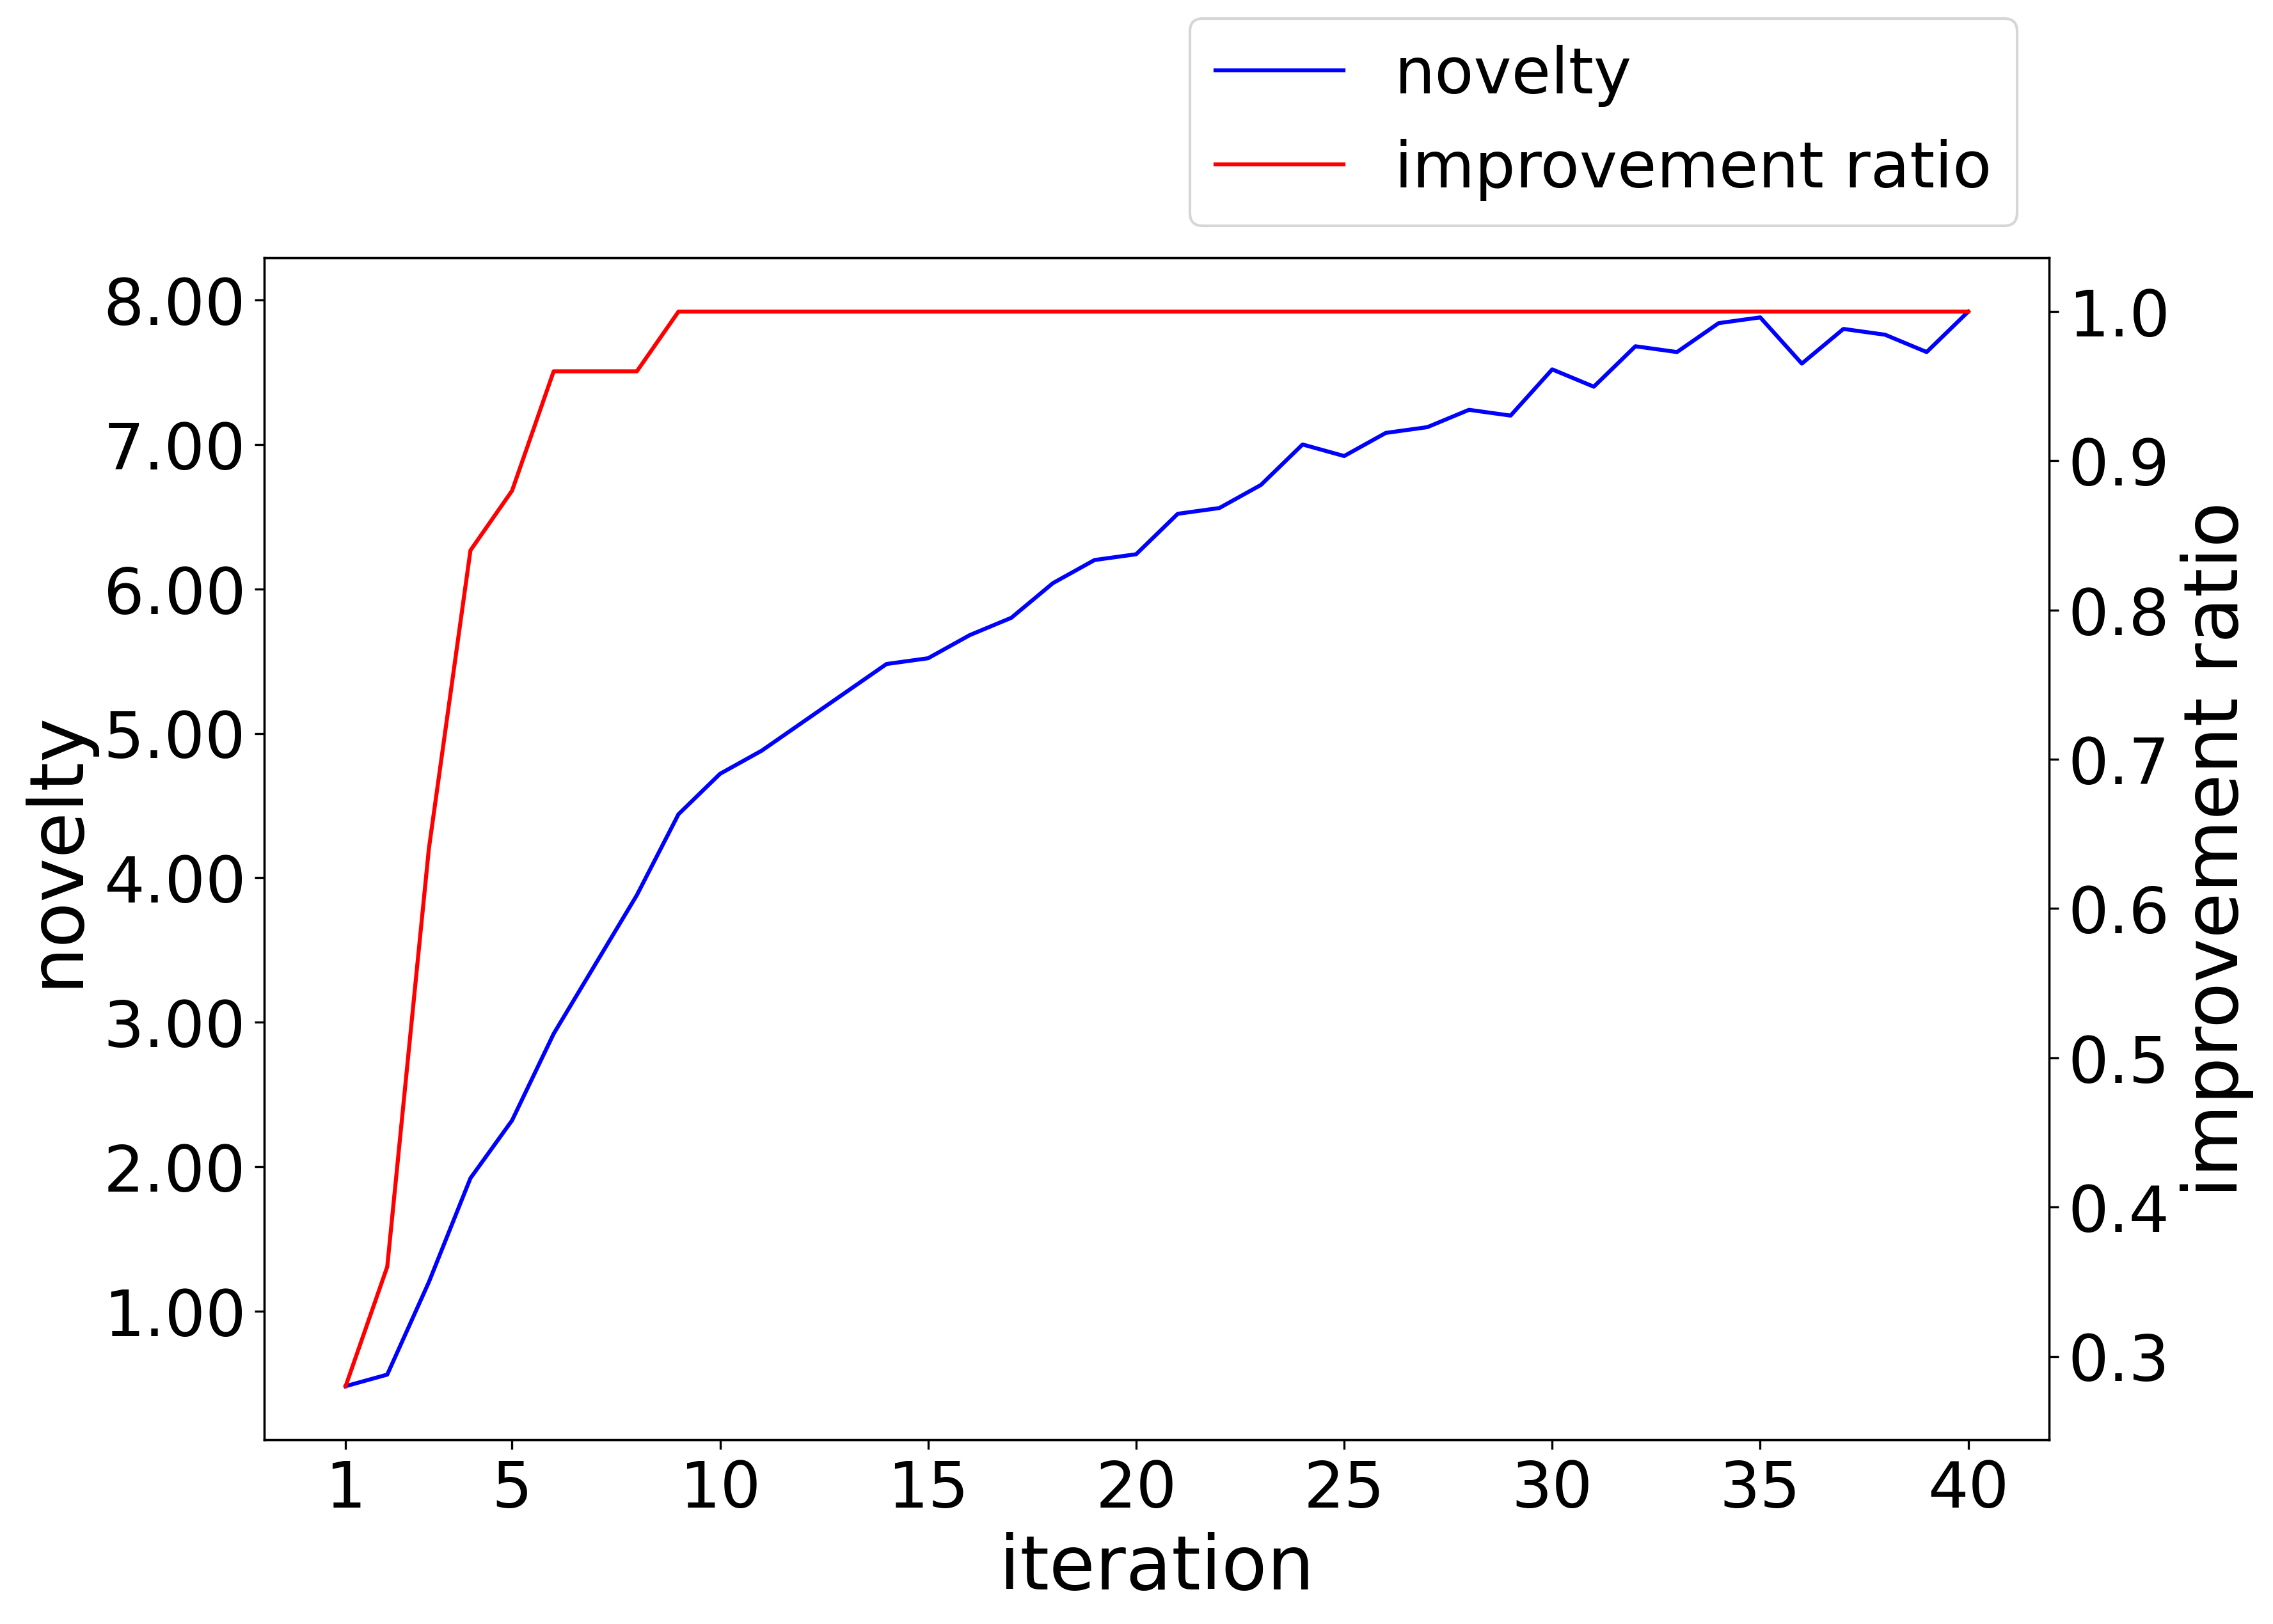

In [14]:
import numpy as np
import matplotlib.pyplot as plt
params = {
    'axes.labelsize': 24,
    'axes.titlesize':24,
    'font.size': 24, 
    'legend.fontsize': 24,
    'xtick.labelsize': 24, 
    'ytick.labelsize': 24,
}
plt.rcParams.update(params)

# plt.rcParams['font.size'] = 36
# plt.tick_params(labelsize=36)
x = np.linspace(start = 0,stop = 39, num=40)

# y1 = list(map(float, y1))
# y2 = list(map(float, y2))
fig = plt.figure(figsize=(12,8),dpi=300)
ax = fig.add_subplot(111)
ax.plot(x,novelty_list[:40], '-', label = 'novelty', color='blue')

ax.yaxis.set_major_formatter('{:.2f}'.format)
ax2 = ax.twinx()
ax2.plot(x,better_list[:40], '-r', label = 'improvement ratio', color='red')
fig.legend(loc=4, bbox_to_anchor=(1,1), bbox_transform=ax.transAxes)
ax.set_xticks([0,4,9,14,19,24,29,34,39])
ax.set_xticklabels(['1','5','10','15','20','25','30','35','40'])
ax.set_xlabel("iteration", fontsize=28)
ax.set_ylabel(r"novelty", fontsize=28)
ax2.set_ylabel(r"improvement ratio",fontsize=28)
plt.savefig(f'figure/binding_novelty-improvement.svg')